# **Stockmarket Prediction with Headlines**

# Train Model - Prediction Abbreviation

## Setup Spark

In [1]:
# Import the findspark module 
import findspark

# Initialize via the full spark path
findspark.init("/usr/local/spark/")

In this section, we initialize the SparkSession, which is the primary entry point for using Spark functionality. We set the master to local and name the application "NLP share price prediction". 
We also create a SparkContext, which represents the connection to a Spark cluster. This can be used for creating RDDs (Resilient Distributed Datasets) and broadcasting variables on that cluster.
Finally, we initialize SQLContext, which is the entry point for working with structured data (rows and columns) in Spark. It allows us to execute SQL queries as well as read and write data in 
various structured formats.

In [2]:
# Import the SparkSession and SQLContext modules
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

# Build the SparkSession
spark = SparkSession.builder \
    .master("local") \
    .appName("NLP share price prediction") \
    .getOrCreate()
    
   
# Main entry point for Spark functionality. A SparkContext represents the
# connection to a Spark cluster, and can be used to create :class:`RDD` and
# broadcast variables on that cluster.      
sc = spark.sparkContext

# The entry point for working with structured data (rows and columns) in Spark
sqlContext = SQLContext(sc)

## Install Packages

### In this section, we install two Python libraries, `nltk` and `langid`, which are essential for natural language processing (NLP). We use pip, the package installer for Python, to install these libraries in the current Jupyter kernel.

#### Additionally, we download a few datasets from the `nltk` library:
- `averaged_perceptron_tagger`: This is used for part-of-speech tagging, which is the process of assigning a POS tag (noun, verb, adjective, etc.) to each word in the input text.
- `stopwords`: This dataset contains common words (such as 'is', 'at', 'which', 'on') that typically don't carry much meaning and are often removed from texts.
- `wordnet`: A lexical database for the English language, which helps the script to determine the base word. It is used for finding the meanings of words, synonyms, antonyms, and more.

In [3]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install nltk --no-cache-dir

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install langid --no-cache-dir

# Download averaged_perceptron_tagger from the nltk
import nltk
nltk.download('averaged_perceptron_tagger')

# Download stopwords from the nltk
import nltk
nltk.download('stopwords')

# Download wordnet from the nltk
import nltk
nltk.download('wordnet')

     |████████████████████████████████| 1.5 MB 23.2 MB/s eta 0:00:01
     |████████████████████████████████| 772 kB 41.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 13.4 MB/s eta 0:00:01
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941189 sha256=152dfd95798954fbec71dad85f44fe2cc11eb3e8323070b3fa7075c6b4b45b5d
  Stored in directory: /tmp/pip-ephem-wheel-cache-tjdfiiit/wheels/c5/01/a4/0160c55074707b535a6757a541842817d530d8080ca943a107
Successfully built langid


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Importing Machine Learning Libraries

In this section, we import essential libraries and modules from PySpark that are required for feature extraction and machine learning:

- `HashingTF`: This stands for Hashing Term Frequency. It is a transformer which takes sets of terms and converts those sets into fixed-length feature vectors.
- `IDF`: This stands for Inverse Document Frequency. It is an estimator which scales features by computing the inverse document frequency of a term in the dataset.
- `Tokenizer`: This is a transformer which converts the input string into lowercase and then splits it by white spaces.
- `NaiveBayes`: This is an estimator for training Naive Bayes classifiers.
- `MulticlassClassificationEvaluator`: This is an evaluator for multiclass classification, which expects two input columns: prediction and label.ages

In [4]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Training Process

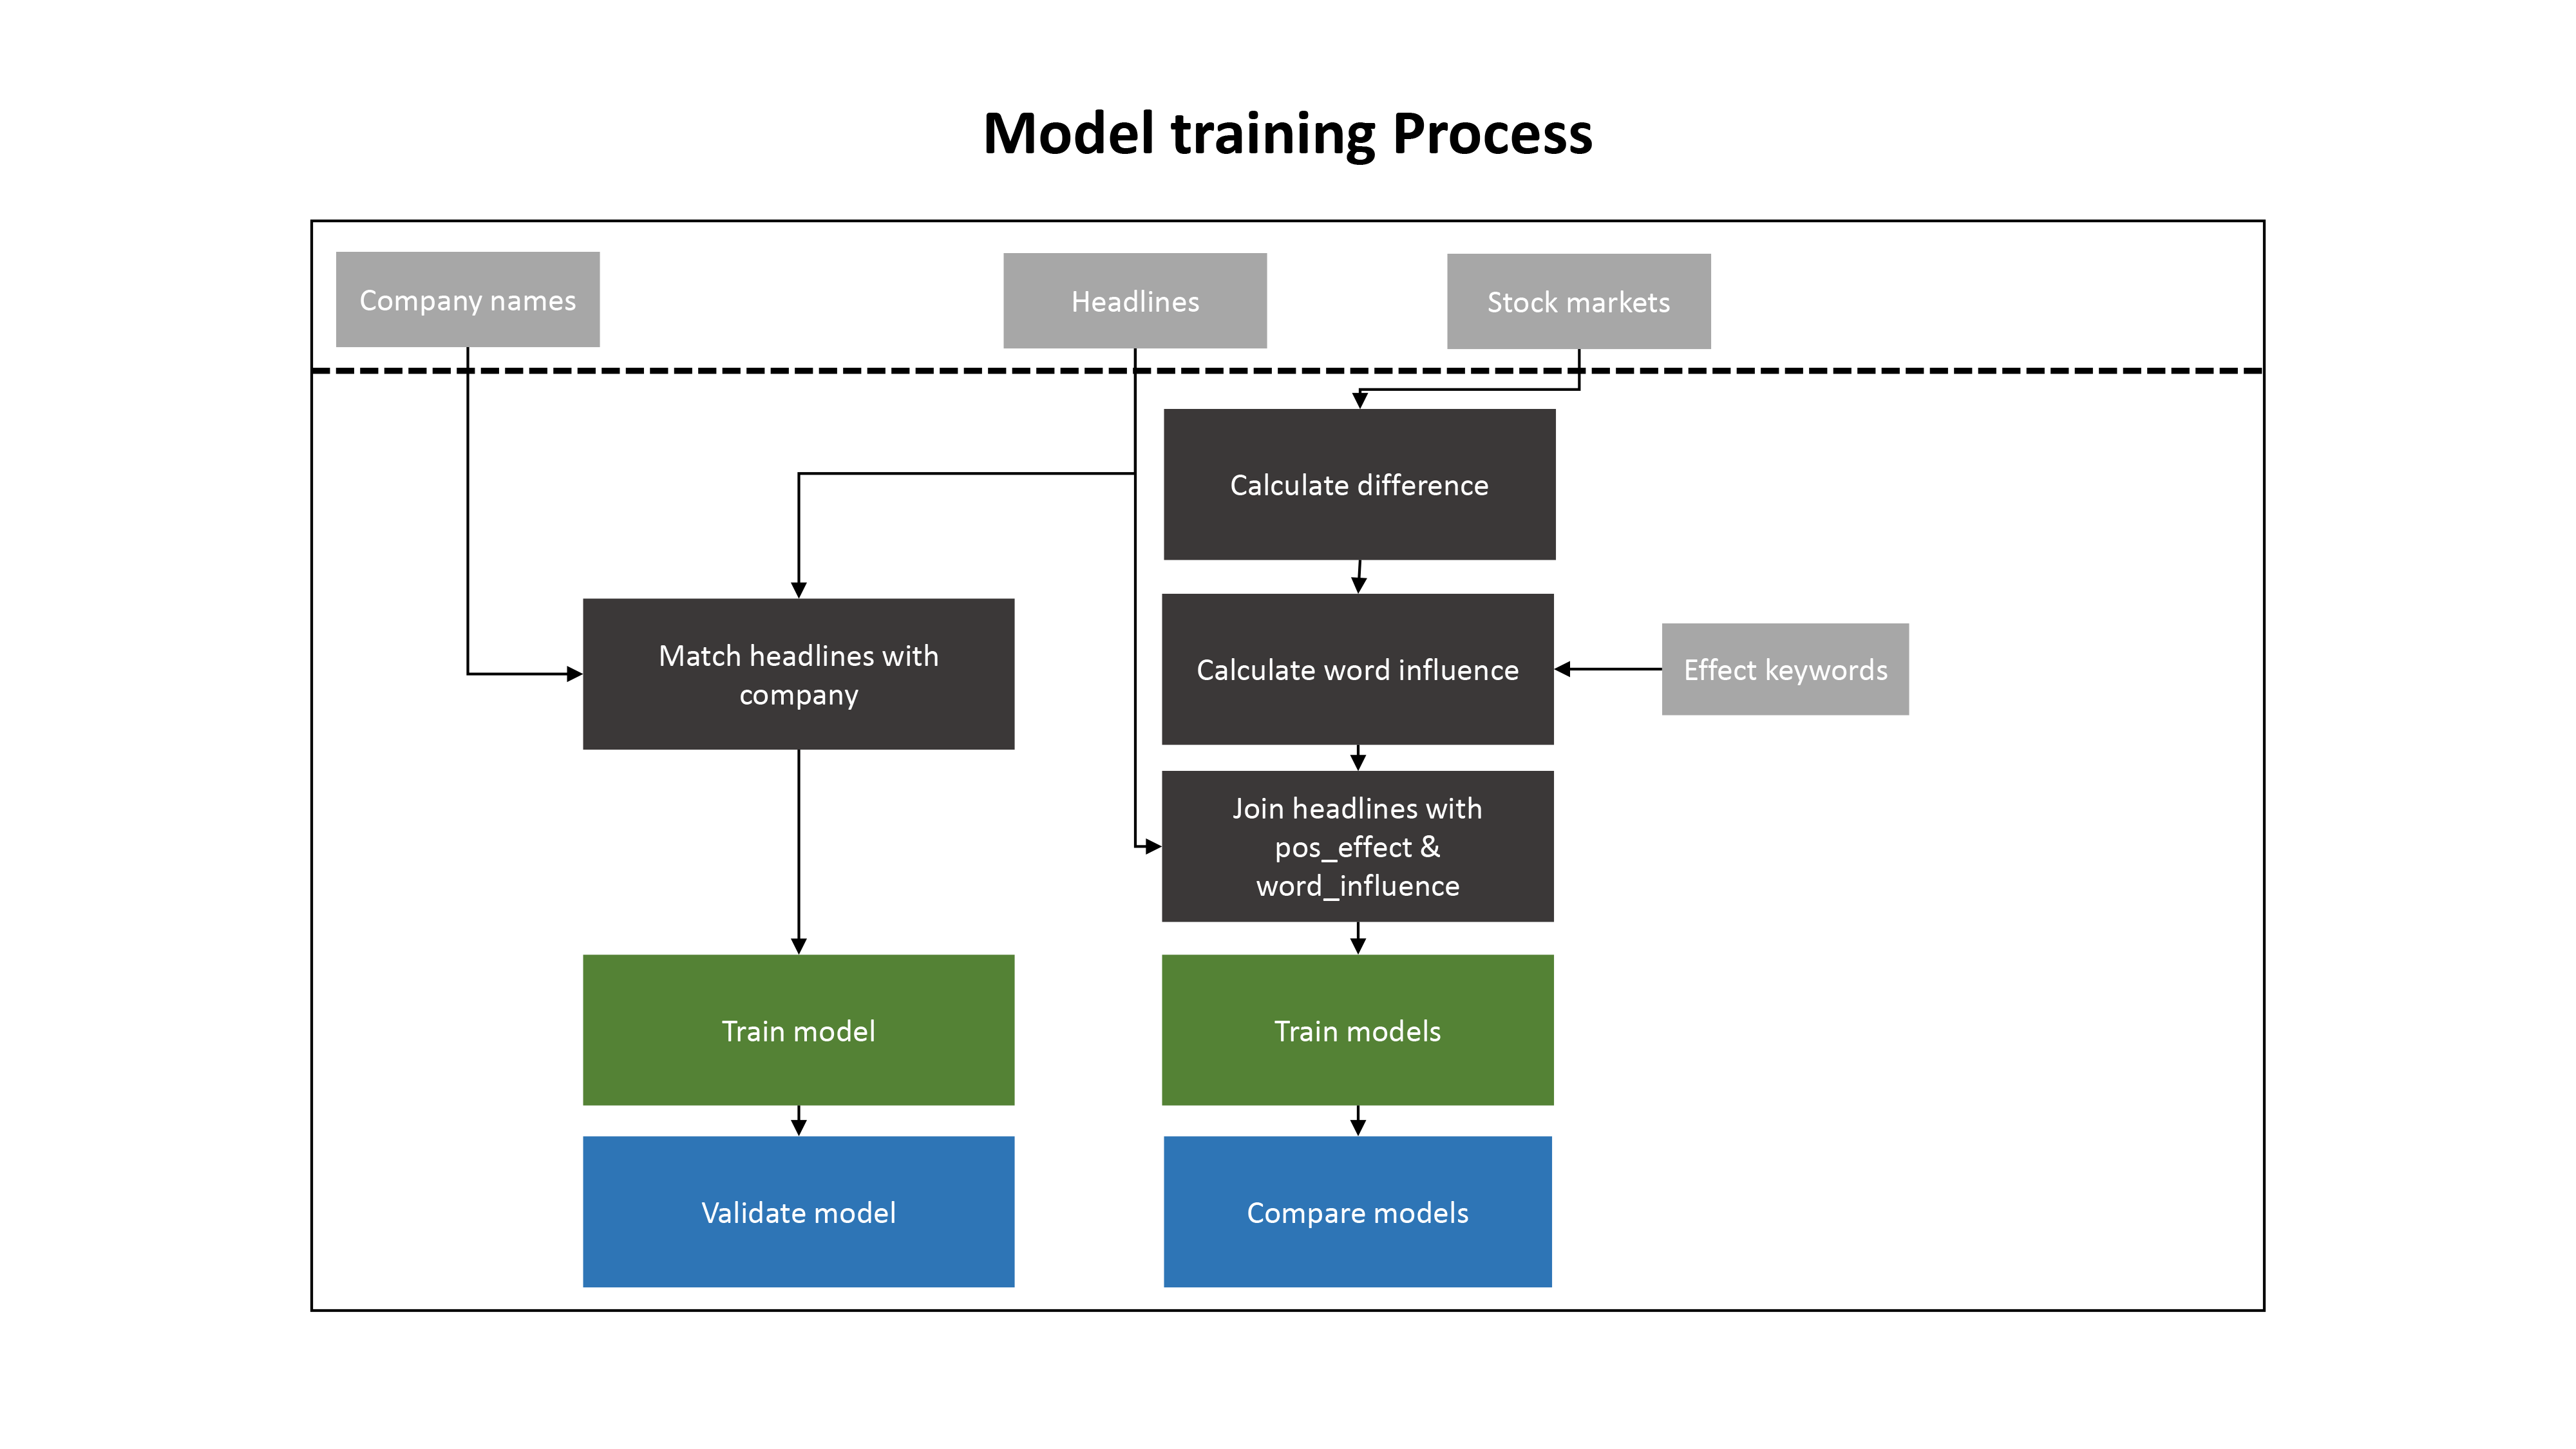

## Data Processing

In this section, we focus on loading and processing the dataset. Due to computational limitations, we are using a subset of the dataset containing 1000 rows of headlines.

- We import the necessary packages for handling data types.
- We attempt to load the dataset into a DataFrame using Spark's `read.csv` method.
- We rename the columns to more descriptive names such as "id", "text", "url", "publisher", "date", and "label_string".
- We drop the columns "url" and "publisher" as they are not needed for our analysis.
- If there is an error while reading the file, an error message is printed.
- Finally, we display the first 3 rows of the dataset, print the schema, and display the total number of rows loaded.

In [5]:
# import package
from pyspark.sql.types import FloatType

# error handling for reading file
try:
    # Load the dataset into a DataFrame
    dataFile = spark.read.csv("data/headlines/headlines_1000rows.csv", inferSchema=False, header=True)

    # add headers
    #data = dataFile.toDF(*["id","text","url","publisher","date","label"])
    data = dataFile.toDF(*["id","text","url","publisher","date","label_string"])
    
    data = data.drop("url","publisher")

except:
    print("error while reading file!")
else:
    # show the results
    data.show(3)
    data.printSchema()
    print(data.count())

+---+--------------------+--------------------+------------+
| id|                text|                date|label_string|
+---+--------------------+--------------------+------------+
|  0|Stocks That Hit 5...|2020-06-05 10:30:...|           A|
|  1|Stocks That Hit 5...|2020-06-03 10:45:...|           A|
|  2|71 Biggest Movers...|2020-05-26 04:30:...|           A|
+---+--------------------+--------------------+------------+
only showing top 3 rows

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- date: string (nullable = true)
 |-- label_string: string (nullable = true)

919


## Machine learning

In this section, we split the dataset into two parts: a training set and a testing set. This is a common practice in machine learning to evaluate the performance of models. 

- We use the `randomSplit` method to divide the dataset. 
- We allocate 90% of the data to the training set and 10% to the testing set.
- We set a seed value of 123 to ensure that the split is reproducible. This means that each time the code is run, the data will be split in the same way.
- We print the number of records in the training and testing datasets.
- Finally, we display the first 5 records of both the training and testing datasets.

In [6]:
# Split the dataset into training and testing sets, with seed for reproducibility
(trainingData, testingData) = data.randomSplit([0.9, 0.1], seed=123)
print(trainingData.count())
print(testingData.count())
trainingData.show(5)
testingData.show(5)

833
86
+---+--------------------+--------------------+------------+
| id|                text|                date|label_string|
+---+--------------------+--------------------+------------+
|  0|Stocks That Hit 5...|2020-06-05 10:30:...|           A|
|  1|Stocks That Hit 5...|2020-06-03 10:45:...|           A|
|100|Top 10 Movers Via...| 2019-08-16 00:00:00|           A|
|101|75 Biggest Movers...| 2019-08-16 00:00:00|           A|
|102|46 Stocks Moving ...| 2019-08-15 00:00:00|           A|
+---+--------------------+--------------------+------------+
only showing top 5 rows

+-------+--------------------+-------------------+------------+
|     id|                text|               date|label_string|
+-------+--------------------+-------------------+------------+
|     10|30 Stocks Moving ...|2020-05-22 00:00:00|           A|
|    103|Agilent Technolog...|2019-08-15 00:00:00|           A|
|1041716|FDA Approves Port...|2018-05-04 00:00:00|        PTLA|
|1041727|34 Stocks Moving ...|2018-

## Feature Extraction and Transformation

In this section, we define the Natural Language Processing (NLP) pipeline and perform feature extraction and transformation:

1. **Tokenization**: We use the `Tokenizer` transformer to convert the text data into a list of words. The `inputCol` parameter specifies the name of the input column ("text"), and the `outputCol` parameter specifies the name of the output column ("words").

2. **Term Frequency**: We use the `HashingTF` transformer to convert the list of words into term frequency vectors. The `inputCol` parameter specifies the name of the input column (output of the tokenizer), and the `outputCol` parameter specifies the name of the output column ("features").

3. **Label Indexing**: We use the `StringIndexer` estimator to convert the string labels into numerical indices. The `inputCol` parameter specifies the name of the input column ("label_string"), and the `outputCol` parameter specifies the name of the output column ("labelIndex"). The `handleInvalid` parameter is set to 'skip' to skip any unseen labels.

We display the first 5 records after each transformation to observe the changes in the dataset.

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession
 
# Define the NLP pipeline
tokenizer = Tokenizer(inputCol="text", outputCol="words")
token_data = tokenizer.transform(trainingData)

token_data.show(5)

hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
hashing_data = hashingTF.transform(token_data)

hashing_data.show(5)

labelIndexer = StringIndexer(inputCol="label_string", outputCol="labelIndex", handleInvalid='skip')
labeled_model = labelIndexer.fit(hashing_data)
labeled_data = labeled_model.transform(hashing_data)

labeled_data.show(5)

+---+--------------------+--------------------+------------+--------------------+
| id|                text|                date|label_string|               words|
+---+--------------------+--------------------+------------+--------------------+
|  0|Stocks That Hit 5...|2020-06-05 10:30:...|           A|[stocks, that, hi...|
|  1|Stocks That Hit 5...|2020-06-03 10:45:...|           A|[stocks, that, hi...|
|100|Top 10 Movers Via...| 2019-08-16 00:00:00|           A|[top, 10, movers,...|
|101|75 Biggest Movers...| 2019-08-16 00:00:00|           A|[75, biggest, mov...|
|102|46 Stocks Moving ...| 2019-08-15 00:00:00|           A|[46, stocks, movi...|
+---+--------------------+--------------------+------------+--------------------+
only showing top 5 rows

+---+--------------------+--------------------+------------+--------------------+--------------------+
| id|                text|                date|label_string|               words|            features|
+---+--------------------+-----

## Building and Training the Model

In this section, we build and train the logistic regression model using the features extracted in the previous steps:

1. **Define the NLP Pipeline**: We define a pipeline with four stages - Tokenizer, HashingTF, StringIndexer, and LogisticRegression. The pipeline sequentially applies a list of transformations and the estimator (Logistic Regression in this case).

2. **Fit the Pipeline to the Training Data**: We call the `fit` method on the pipeline object and pass in the training data. This trains the model.

3. **Making Predictions**: We use the trained model to make predictions on the test data by calling the `transform` method.

4. **Displaying the Predictions**: We select the "text", "labelIndex", and "prediction" columns from the predictions DataFrame and display them.

This section is crucial as it involves the actual training of the machine learning model using the training data, and then using the model to make predictions on data it has not seen before (test data).

In [8]:
# Define the NLP pipeline
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
labelIndexer = StringIndexer(inputCol="label_string", outputCol="labelIndex")
lr = LogisticRegression(featuresCol="features", labelCol="labelIndex")
pipeline = Pipeline(stages=[tokenizer, hashingTF, labelIndexer, lr])


# Fit the pipeline to the DataFrame
model_stock_abbreviation = pipeline.fit(trainingData)

# Make predictions on the test data
stock_abb_predictions = model_stock_abbreviation.transform(testingData)

# Display the predictions
stock_abb_predictions.select("text", "labelIndex", "prediction").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+----------+
|text                                                                                                                                                                                                 |labelIndex|prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+----------+
|30 Stocks Moving in Friday's Pre-Market Session                                                                                                                                                      |0.0       |1.0       |
|Agilent Technologies shares are trading higher after the company reported better-than-expected Q3 EPS and sales

## Model Evaluation

In this section, we evaluate the performance of the model using the test data:

1. **Create an Evaluator**: We use the `MulticlassClassificationEvaluator` from PySpark. This evaluator can be used to evaluate classification models. We specify that we are interested in evaluating the accuracy of the model by setting the `metricName` parameter to "accuracy".

2. **Evaluate the Model**: We call the `evaluate` method on the evaluator object and pass in the predictions made by the model on the test data. This returns the accuracy of the model.

3. **Display the Accuracy**: We print the accuracy of the model in percentage format.

Evaluating the model is an essential step in the machine learning pipeline because it provides an estimate of how well the model is likely to perform on unseen data.

In [9]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate the accuracy of the model
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(stock_abb_predictions)

print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 83.72%


Accuracy pretty good - can be improved by training more data (we dont have the capacity)

# Train Model - Prediction Share Price

In this section, we load the raw analyst ratings data:

1. **Import Necessary Modules**: We import `FloatType` from `pyspark.sql.types` which might be used for type conversion later.

2. **Load Data**: We attempt to load the dataset from the file `raw_analyst_ratings.csv` into a DataFrame. This file contains raw analyst ratings data.

3. **Data Processing**: We keep only the relevant columns - "text", "date", and "label", and drop the others like "id", "url", and "publisher".

4. **Error Handling**: In case there is an error while reading the file, an error message is printed. If the file is read successfully, we display the first 6 rows of the DataFrame and print the total number of rows in the dataset.

This step is crucial as it involves loading the data which will be used for further analysis and model training.

In [10]:
# import package
from pyspark.sql.types import FloatType

# error handling for reading file
try:
    # Load the dataset into a DataFrame
    dataFile = spark.read.csv("data/headlines/raw_analyst_ratings.csv", inferSchema=False, header=True)

    # add headers
    #data = dataFile.toDF(*["id","text","url","publisher","date","label"])
    data = dataFile.toDF(*["id","text","url","publisher","date","label"])
    
    data = data.drop("id", "url", "publisher")

except:
    print("error while reading file!")
else:
    # show the results
    data.show(6)
    print(data.count())

+--------------------+--------------------+-----+
|                text|                date|label|
+--------------------+--------------------+-----+
|Stocks That Hit 5...|2020-06-05 10:30:...|    A|
|Stocks That Hit 5...|2020-06-03 10:45:...|    A|
|71 Biggest Movers...|2020-05-26 04:30:...|    A|
|46 Stocks Moving ...|2020-05-22 12:45:...|    A|
|B of A Securities...|2020-05-22 11:38:...|    A|
|CFRA Maintains Ho...|2020-05-22 11:23:...|    A|
+--------------------+--------------------+-----+
only showing top 6 rows

1407328


## Formatting the Date Column

In this section, the date column in the DataFrame is formatted:

1. **Date Formatting**: The date column is formatted to the 'yyyy-MM-dd' format using the `date_format` function from `pyspark.sql.functions`. This standardizes the date representation in the dataset.

2. **Display Updated DataFrame**: The first 6 rows of the updated DataFrame are displayed to verify that the date formatting has been applied correctly.

3. **Storing the DataFrame**: The formatted DataFrame is stored in the variable `data_head` for further processing.

Formatting the date column is important for consistency and to ensure that the date values can be easily interpreted and manipulated in later stages of data processing.

In [11]:
from pyspark.sql.functions import col, date_format

# Format the date column to yyyy-mm-dd
data = data.withColumn("date", date_format(col("date"), "yyyy-MM-dd"))

# Show the updated DataFrame
data.show(6)

data_head = data

+--------------------+----------+-----+
|                text|      date|label|
+--------------------+----------+-----+
|Stocks That Hit 5...|2020-06-05|    A|
|Stocks That Hit 5...|2020-06-03|    A|
|71 Biggest Movers...|2020-05-26|    A|
|46 Stocks Moving ...|2020-05-22|    A|
|B of A Securities...|2020-05-22|    A|
|CFRA Maintains Ho...|2020-05-22|    A|
+--------------------+----------+-----+
only showing top 6 rows



## Loading and Processing Stock Data

In this section, the stock data is loaded into a DataFrame and processed:

1. **Importing Required Modules**: The `FloatType` module from `pyspark.sql.types` and the `col` and `lit` functions from `pyspark.sql.functions` are imported.

2. **Loading Data**: The stock data is loaded from a CSV file into a DataFrame. The file contains stock data for a specific stock symbol (in this case, "A").

3. **Renaming Columns and Dropping Unnecessary Columns**: The columns in the DataFrame are renamed for clarity. The columns "high", "low", "adj_close", and "volume" are dropped as they are not needed for the analysis.

4. **Adding a New Column**: A new column named "label" is added to the DataFrame with a constant value "A", representing the stock symbol.

5. **Error Handling**: If there is an error while reading the file, an error message is printed.

6. **Displaying the DataFrame**: The first 6 rows of the DataFrame are displayed to verify that the data has been loaded and processed correctly. The total number of rows in the DataFrame is also printed.

This step is crucial for preparing the stock data for further analysis and modeling.

In [12]:
# import package
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col, lit

# error handling for reading file
try:
    # Load the dataset into a DataFrame
    dataFile = spark.read.csv("data/shares/stocks/A.csv", inferSchema=False, header=True)

    # add headers
    # Date,Open,High,Low,Close,Adj Close,Volume
    data = dataFile.toDF(*["date","open","high","low","close","adj_close","volume"])
    
    data = data.drop("high", "low", "adj_close", "volume")
    
    # Add a new column "label" with the value "AAPL"
    data = data.withColumn("label", lit("A"))

except:
    print("error while reading file!")
else:
    # show the results
    data.show(6)
    print(data.count())

+----------+------------------+------------------+-----+
|      date|              open|             close|label|
+----------+------------------+------------------+-----+
|1999-11-18| 32.54649353027344|31.473533630371094|    A|
|1999-11-19|30.713520050048828|28.880542755126953|    A|
|1999-11-22|29.551143646240234|31.473533630371094|    A|
|1999-11-23|30.400571823120117|28.612302780151367|    A|
|1999-11-24|28.701717376708984|29.372318267822266|    A|
|1999-11-26|29.238197326660156| 29.46173095703125|    A|
+----------+------------------+------------------+-----+
only showing top 6 rows

5124


## Calculating Stock Price Difference and Filtering Data

In this section, the stock data is further processed:

1. **Calculating Price Difference**: A new column named "difference" is created in the DataFrame. This column stores the difference between the opening and closing prices of the stock for each day.

2. **Filtering Out Rows with Zero Difference**: Rows where the difference between the opening and closing prices is zero are filtered out. This is done to focus on days where there was a change in the stock price.

3. **Dropping Columns**: The "open" and "close" columns are dropped from the DataFrame as they are no longer needed after calculating the difference.

4. **Displaying the DataFrame**: The first 20 rows of the updated DataFrame are displayed to verify the changes.

5. **Storing the DataFrame for Later Use**: The processed DataFrame is stored in a variable named `data_stock` for later use in the analysis.

This processing step is essential for preparing the data for analysis and modeling, as it reduces the dataset to relevant features and filters out uninformative rows.

In [13]:
from pyspark.sql.functions import col

# Subtract "close" from "open" and create a new column "difference"
data = data.withColumn("difference", col("open") - col("close"))

# Filter out rows with a difference of 0
data = data.filter(col("difference") != 0)

# Drop the "open" and "close" columns
data = data.drop("open", "close")

# Show the updated DataFrame
data.show(20)

data_stock = data

+----------+-----+--------------------+
|      date|label|          difference|
+----------+-----+--------------------+
|1999-11-18|    A|  1.0729598999023438|
|1999-11-19|    A|   1.832977294921875|
|1999-11-22|    A| -1.9223899841308594|
|1999-11-23|    A|    1.78826904296875|
|1999-11-24|    A| -0.6706008911132812|
|1999-11-26|    A|-0.22353363037109375|
|1999-11-29|    A| -0.8047218322753906|
|1999-11-30|    A|-0.13411903381347656|
|1999-12-01|    A| -0.5364818572998047|
|1999-12-02|    A|-0.26823997497558594|
|1999-12-03|    A|  0.3129463195800781|
|1999-12-06|    A| -0.3576545715332031|
|1999-12-07|    A|  0.3576545715332031|
|1999-12-08|    A|   0.044708251953125|
|1999-12-09|    A| -0.4023590087890625|
|1999-12-10|    A|  0.6706008911132812|
|1999-12-14|    A|  1.6988544464111328|
|1999-12-15|    A| 0.22353363037109375|
|1999-12-16|    A| -3.7553634643554688|
|1999-12-17|    A|  0.3129463195800781|
+----------+-----+--------------------+
only showing top 20 rows



## Joining DataFrames and Creating a New Feature

In this section, the previously prepared DataFrames `data_head` (containing headlines) and `data_stock` (containing stock price differences) are joined to create a combined DataFrame. The joining is performed based on the "date" and "label" columns.

1. **Joining DataFrames**: The `join` method is used to join `data_head` and `data_stock` DataFrames. The columns used for joining are "date" and "label". The type of join used is "inner", which means that only the rows with matching values in both DataFrames will be included in the result.

2. **Creating a New Feature**: A new column named "positive_effect" is added to the joined DataFrame. This column indicates whether the stock price difference is positive or not. If the difference is greater than or equal to 0, "positive_effect" is set to 1, otherwise, it is set to 0. This is done using the `when` function from the `pyspark.sql.functions` module.

3. **Displaying the DataFrame**: The first 20 rows of the joined DataFrame are displayed to verify the changes.

This step is crucial for combining the information from the headlines and stock prices into a single DataFrame, which can then be used for further analysis and modeling.

In [14]:
# Join the data DataFrames by "date" and "label"
data_joined = data_head.join(data_stock, ["date", "label"], "inner")

from pyspark.sql.functions import col, when

# Add a new column "positive_effect" based on the "difference" column
data_joined = data_joined.withColumn("positive_effect", when(col("difference") >= 0, 1).otherwise(0))

# Show the joined DataFrame
data_joined.show(20)

+----------+-----+--------------------+-------------------+---------------+
|      date|label|                text|         difference|positive_effect|
+----------+-----+--------------------+-------------------+---------------+
|2020-04-01|    A|Shares of several...| 0.5500030517578125|              1|
|2020-03-31|    A|Int'l. Air Transp...| 0.7199935913085938|              1|
|2020-03-30|    A|Wells Fargo Maint...|-1.6100006103515625|              0|
|2020-03-30|    A|Shares of several...|-1.6100006103515625|              0|
|2020-03-27|    A|Shares of several...| 0.6399993896484375|              1|
|2020-03-26|    A|Shares of several...| -3.720001220703125|              0|
|2020-03-26|    A|Barclays Maintain...| -3.720001220703125|              0|
|2020-03-26|    A|Ariel Chairman Jo...| -3.720001220703125|              0|
|2020-03-20|    A|Citigroup Maintai...| -0.470001220703125|              0|
|2020-03-16|    A|Stocks That Hit 5...|-0.7199974060058594|              0|
|2020-03-16|

## Dropping Column and Displaying DataFrame

In this section, the "difference" column is dropped from the `data_joined` DataFrame. This column is no longer needed for the analysis and modeling.
Except we try to use it for linear regression to see how far the headline influenced the stockmarket.

1. **Dropping Columns**: The `drop` method is used to remove the "difference" column from the `data_joined` DataFrame. This is done by specifying the column name as an argument to the `drop` method.

2. **Displaying the DataFrame**: The updated DataFrame is then displayed to verify that the "difference" column has been successfully dropped.

This step helps to clean up the DataFrame by removing unnecessary columns and keeping only the relevant features for further analysis and modeling.


In [15]:
# Drop the "open" and "close" columns
data_joined = data_joined.drop("difference")

# Show the updated DataFrame
data_joined.show(20)

+----------+-----+--------------------+---------------+
|      date|label|                text|positive_effect|
+----------+-----+--------------------+---------------+
|2020-04-01|    A|Shares of several...|              1|
|2020-03-31|    A|Int'l. Air Transp...|              1|
|2020-03-30|    A|Wells Fargo Maint...|              0|
|2020-03-30|    A|Shares of several...|              0|
|2020-03-27|    A|Shares of several...|              1|
|2020-03-26|    A|Shares of several...|              0|
|2020-03-26|    A|Barclays Maintain...|              0|
|2020-03-26|    A|Ariel Chairman Jo...|              0|
|2020-03-20|    A|Citigroup Maintai...|              0|
|2020-03-16|    A|Stocks That Hit 5...|              0|
|2020-03-16|    A|Shares of several...|              0|
|2020-03-13|    A|Shares of several...|              0|
|2020-03-12|    A|Stocks That Hit 5...|              1|
|2020-03-11|    A|Shares of several...|              1|
|2020-03-03|    A|Agilent Technolog...|         

## Data Preprocessing and Splitting

In this section, the `data_joined` DataFrame is preprocessed and split into training and testing datasets.

1. **Convert Column Type**: The "positive_effect" column in the `data_joined` DataFrame is converted to the integer type using the `withColumn` method and `cast` function.

2. **Splitting the Data**: The `randomSplit` method is used to split the data into training and testing datasets. The argument `[0.85, 0.15]` specifies the proportions for the training and testing datasets respectively. The `seed` parameter is set to `123` for reproducibility.

3. **Displaying the Datasets**: The first 3 rows of the training and testing datasets are displayed using the `show` method to verify the successful split.

This step prepares the data for model training by converting the target variable to the appropriate type and splitting the data into separate datasets for training and evaluation.



In [16]:
from pyspark.ml.feature import StringIndexer, Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Convert the "positive_effect" column to integer type
joinedData = data_joined.withColumn("positive_effect", data_joined["positive_effect"].cast("int"))

# Split the data into training and testing datasets
(trainingData, testData) = joinedData.randomSplit([0.85, 0.15],seed=123)

trainingData.show(3)
testData.show(3)

+----------+-----+--------------------+---------------+
|      date|label|                text|positive_effect|
+----------+-----+--------------------+---------------+
|2009-04-29|    A|Going Against the...|              0|
|2009-06-01|    A|super-trades - Tw...|              0|
|2009-07-30|    A|The Gold/Silver R...|              0|
+----------+-----+--------------------+---------------+
only showing top 3 rows

+----------+-----+--------------------+---------------+
|      date|label|                text|positive_effect|
+----------+-----+--------------------+---------------+
|2009-07-14|    A|Skystar Bio-Pharm...|              0|
|2009-08-06|    A|Connecticut Shop ...|              1|
|2009-08-07|    A|"ERA Ecosystem Re...|              0|
+----------+-----+--------------------+---------------+
only showing top 3 rows



## Pipeline Stages Definition

In this section, the stages of the pipeline for the NLP classification model are defined. Each stage performs a specific data transformation or model training step.

1. **Tokenizer**: The `Tokenizer` stage is used to tokenize the input text column into individual words. It takes an input column specified by `inputCol` and outputs the tokenized words to the `outputCol`.

2. **StopWordsRemover**: The `StopWordsRemover` stage removes common stop words from the tokenized words. It takes an input column specified by `inputCol` (which should be the output of the `Tokenizer` stage) and outputs the filtered words to the `outputCol`.

3. **HashingTF**: The `HashingTF` stage converts the filtered words into numerical feature vectors using the hashing trick. It takes an input column specified by `inputCol` (which should be the output of the `StopWordsRemover` stage) and outputs the raw feature vectors to the `outputCol`.

4. **IDF**: The `IDF` stage calculates the Inverse Document Frequency (IDF) for the raw feature vectors. It takes an input column specified by `inputCol` (which should be the output of the `HashingTF` stage) and outputs the IDF-weighted feature vectors to the `outputCol`.

5. **StringIndexer**: The `StringIndexer` stage indexes the target variable (positive_effect) as numeric labels. It takes an input column specified by `inputCol` (which should be the target variable) and outputs the indexed labels to the `outputCol`.

6. **LogisticRegression**: The `LogisticRegression` stage defines the logistic regression model for classification. It takes the feature vectors specified by `featuresCol` and the indexed labels specified by `labelCol` as input.

These stages are the building blocks of the pipeline and define the data transformations and model training steps for the NLP classification model.


In [17]:
# Define the stages of the pipeline
tokenizer = Tokenizer(inputCol="text", outputCol="words")
stopWordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")
labelIndexer = StringIndexer(inputCol="positive_effect", outputCol="label_pre")

# Define the logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label_pre")

## Create the Pipeline

The first step is to create a pipeline for training a logistic regression model on the share price prediction dataset. The pipeline consists of several stages:

1. **Tokenizer**: This stage tokenizes the input text into individual words.
2. **StopWordsRemover**: This stage removes common stop words from the tokenized words.
3. **HashingTF**: This stage converts the tokenized words into numerical features using the hashing trick.
4. **IDF**: This stage applies Inverse Document Frequency (IDF) weighting to the features.
5. **StringIndexer**: This stage converts the target variable "positive_effect" into numerical labels.
6. **LogisticRegression**: This stage trains a logistic regression model using the features and labels.

### Train the Model
Next, the pipeline is fit on the training data to train the logistic regression model. This step involves transforming the data through each stage of the pipeline and training the model using the transformed data.

### Make Predictions
Once the model is trained, it is used to make predictions on the test data. The `transform()` method is called on the trained model, which applies the pipeline transformations to the test data and generates predictions.

### Display Predictions
The predictions are stored in the `share_price_predictions` DataFrame. The following code snippet shows the first 15 rows of the predictions DataFrame, displaying the original text, actual label, and predicted label.

In [18]:
# Create the pipeline
pipeline = Pipeline(stages=[tokenizer, stopWordsRemover, hashingTF, idf, labelIndexer, lr])

# Train the model
model_share_price = pipeline.fit(trainingData)

# Make predictions on the test data
share_price_predictions = model_share_price.transform(testData)

share_price_predictions.show(15)

+----------+-----+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----------+
|      date|label|                text|positive_effect|               words|      filtered_words|        raw_features|            features|label_pre|       rawPrediction|         probability|prediction|
+----------+-----+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----------+
|2009-07-14|    A|Skystar Bio-Pharm...|              0|[skystar, bio-pha...|[skystar, bio-pha...|(262144,[3968,142...|(262144,[3968,142...|      0.0|[255.335122900447...|[1.0,1.2863675862...|       0.0|
|2009-08-06|    A|Connecticut Shop ...|              1|[connecticut, sho...|[connecticut, sho...|(262144,[1928,121...|(262144,[1928,121...|      1.0|[69.0484721644578...|[1.0,1.0295075955.

## Evaluate the Accuracy

To evaluate the accuracy of the share price prediction model, a `MulticlassClassificationEvaluator` is used. The evaluator compares the predicted labels with the actual labels in the test data and calculates the accuracy.

In [19]:
# Evaluate the accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label_pre", predictionCol="prediction", metricName="accuracy")
accuracy_normal_reg = evaluator.evaluate(share_price_predictions)

print("Accuracy: {:.2%}".format(accuracy_normal_reg))

Accuracy: 68.04%


## Feature Extraction and Classification for other models

The next step in the share price prediction process involves feature extraction and classification using different classifiers. The `text` column is converted into an array of strings to enable further feature extraction.

In [20]:
from pyspark.sql.functions import split
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF

# Convert the "text" column to an array of strings
data_joined = data_joined.withColumn("text_array", split(data_joined["text"], " "))

# Define the feature extraction pipeline
vectorizer = CountVectorizer(inputCol="text_array", outputCol="features")
idf = IDF(inputCol="features", outputCol="features_idf")

# Define the classifiers
randomForest = RandomForestClassifier(labelCol="positive_effect", featuresCol="features_idf")
gradientBoosting = GBTClassifier(labelCol="positive_effect", featuresCol="features_idf")
svm = LinearSVC(labelCol="positive_effect", featuresCol="features_idf")

# Create pipelines for each classifier
rfPipeline = Pipeline(stages=[vectorizer, idf, randomForest])
gbtPipeline = Pipeline(stages=[vectorizer, idf, gradientBoosting])
svmPipeline = Pipeline(stages=[vectorizer, idf, svm])

# Split the data into training and test sets
(trainingData, testData) = data_joined.randomSplit([0.85, 0.15], seed=123)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="positive_effect", metricName="accuracy")

## Accuracy of Random Forest

The following code snippet fits a Random Forest model using the training data, makes predictions on the test data, and evaluates the accuracy of the model. The accuracy of the Random Forest model is then displayed as a percentage with two decimal places. This metric provides insights into the performance of the model in predicting the target variable.

In [21]:
# Fit the model
rfModel = rfPipeline.fit(trainingData)

# Make predictions on the test set
rfPredictions = rfModel.transform(testData)

# Evaluate the accuracy of the model
rfAccuracy = evaluator.evaluate(rfPredictions)

print("Random Forest Accuracy: {:.2%}".format(rfAccuracy))

Random Forest Accuracy: 67.53%


## Accuracy of Gradient Boosting 

The code above fits a Gradient Boosting model using the training data, generates predictions on the test data, and evaluates the accuracy of the model. The accuracy of the Gradient Boosting model is then displayed as a percentage with two decimal places. This accuracy metric provides an assessment of how well the model performs in predicting the target variable.

In [22]:
gbtModel = gbtPipeline.fit(trainingData)
gbtPredictions = gbtModel.transform(testData)
gbtAccuracy = evaluator.evaluate(gbtPredictions)
print("Gradient Boosting Accuracy: {:.2%}".format(gbtAccuracy))

Gradient Boosting Accuracy: 68.56%


## Accuracy of Support Vector Machines

The code above fits a Support Vector Machines (SVM) model using the training data, generates predictions on the test data, and evaluates the accuracy of the model. The accuracy of the SVM model is then displayed as a percentage with two decimal places. This accuracy metric provides an assessment of how well the model performs in predicting the target variable.

In [23]:
svmModel = svmPipeline.fit(trainingData)
svmPredictions = svmModel.transform(testData)
svmAccuracy = evaluator.evaluate(svmPredictions)
print("Support Vector Machines Accuracy: {:.2%}".format(svmAccuracy))

Support Vector Machines Accuracy: 70.10%


## Another approach with an extra feature - positive or negative keywords

The code snippet defines two lists: positive_words and negative_words. These lists contain positive and negative words, respectively, that can be used to analyze sentiment or market conditions in text data. These lists can be used as additional features in classification models.

In [24]:
positive_words = [
    "bullish", "growth", "increase", "profit", "success", "upward", "boom", 
    "opportunity", "promising", "bull market", "advantage", "positive", 
    "strong", "encouraging", "healthy", "improving", "prosperous", "rising",
    "optimistic", "gain", "win", "good", "great", "excellent", "victory",
    "pleased", "satisfactory", "upswing", "benefit", "reward", "pleasure"
]
negative_words = [
    "bearish", "decline", "loss", "sell-off", "failure", "downward", "crash", 
    "risk", "downturn", "bear market", "disadvantage", "negative", "weak", 
    "discouraging", "unhealthy", "worsening", "struggling", "pessimistic", 
    "fall", "loss", "bad", "poor", "disappointing", "defeat", "unsatisfactory",
    "slump", "drawback", "penalty", "pain"
]

The code snippet adds a new column called "word_effect" to the DataFrame. It uses a user-defined function (UDF) named "calculate_word_influence" to calculate the influence of positive and negative words in the "text" column. The UDF splits the text into words, counts the occurrences of positive and negative words, and calculates the difference between the counts. The UDF is then registered and applied to the "text" column using the `withColumn` method. Finally, the updated DataFrame is displayed.

In [25]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

word_counter = 0

def calculate_word_influence(text):
    words = text.lower().split()
    pos_count = sum([1 for word in words if word in positive_words])
    neg_count = sum([1 for word in words if word in negative_words])
    return pos_count - neg_count

# UDF registrieren
calculate_word_influence_udf = udf(calculate_word_influence, IntegerType())

# DataFrame um die word_influence-Spalte erweitern
data_joined = data_joined.withColumn("word_effect", calculate_word_influence_udf(data_joined["text"]))

# Anzeigen des aktualisierten DataFrames
data_joined.show(20, truncate = True)

+----------+-----+--------------------+---------------+--------------------+-----------+
|      date|label|                text|positive_effect|          text_array|word_effect|
+----------+-----+--------------------+---------------+--------------------+-----------+
|2020-04-01|    A|Shares of several...|              1|[Shares, of, seve...|          0|
|2020-03-31|    A|Int'l. Air Transp...|              1|[Int'l., Air, Tra...|          0|
|2020-03-30|    A|Wells Fargo Maint...|              0|[Wells, Fargo, Ma...|          0|
|2020-03-30|    A|Shares of several...|              0|[Shares, of, seve...|          0|
|2020-03-27|    A|Shares of several...|              1|[Shares, of, seve...|          0|
|2020-03-26|    A|Shares of several...|              0|[Shares, of, seve...|          0|
|2020-03-26|    A|Barclays Maintain...|              0|[Barclays, Mainta...|          0|
|2020-03-26|    A|Ariel Chairman Jo...|              0|[Ariel, Chairman,...|          1|
|2020-03-20|    A|Cit

## Text Classification using PySpark's MLlib

This script is designed to perform text classification using PySpark's MLlib. It reads data into a Spark DataFrame and processes the text data through several stages including tokenization, stop word removal, and TF-IDF transformation. The script then applies a logistic regression model for the classification task.


1. **Load Data**: The script assumes that the data is already loaded in a variable named `data_joined`.

2. **Preprocessing**: The text data is tokenized into words, and common stop words are removed. 

3. **Feature Engineering**: It converts the tokenized words into numerical features using Term Frequency-Inverse Document Frequency (TF-IDF).

4. **Label Encoding**: The target variable 'positive_effect' is converted into numerical form.

5. **Vector Assembly**: All the features are assembled into a single vector that will be used for model training.

6. **Data Splitting**: The dataset is split into training and testing sets.

7. **Model Training**: A logistic regression model is trained using the training data.

8. **Prediction**: The trained model is used to make predictions on the testing data.

9. **Evaluation**: The performance of the model is evaluated using the area under the Receiver Operating Characteristic (ROC) curve.

10. **Output**: Prints accuracy of the model

In [26]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, Tokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# Read the table into a Spark DataFrame
data = data_joined

# Convert the 'positive_effect' column to a numeric type
data = data.withColumn("positive_effect", data["positive_effect"].cast("integer"))

# Tokenize the text column
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")

# Remove stopwords from the tokenized text
stopword_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Apply TF-IDF transformation to the filtered tokens
count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")

# Create a StringIndexer to convert text labels into numerical values
label_indexer = StringIndexer(inputCol="positive_effect", outputCol="labelIndex").fit(data)

# Define the input features
input_cols = ['features', 'word_effect']

# Create a VectorAssembler to combine the input features into a feature vector
assembler = VectorAssembler(inputCols=input_cols, outputCol="combined_features")

# Split the data into training and testing sets
(training_data, test_data) = data.randomSplit([0.85, 0.15], seed=123)

# Define the logistic regression model
lr = LogisticRegression(featuresCol="combined_features", labelCol="labelIndex")

# Create a pipeline to chain the stages together
pipeline = Pipeline(stages=[tokenizer, stopword_remover, count_vectorizer, idf, label_indexer, assembler, lr])

# Fit the pipeline to the training data
model_share_price = pipeline.fit(training_data)

# Make predictions on the testing data
share_price_predictions = model_share_price.transform(test_data)

# Evaluate the model using a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="labelIndex")
accuracy = evaluator.evaluate(share_price_predictions, {evaluator.metricName: "areaUnderROC"})

# Print the accuracy
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 69.27%


### Plot the accuracy results

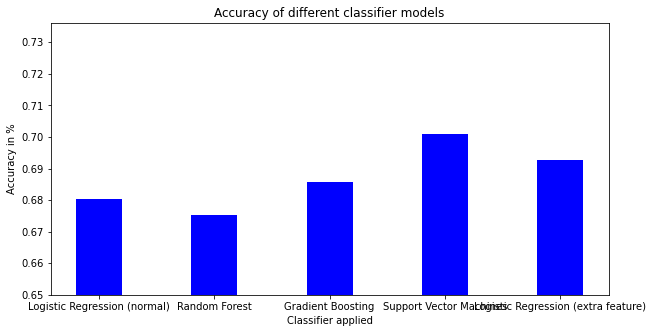

In [33]:
import numpy as np
import matplotlib.pyplot as plt
 
# creating the dataset
data = {'Logistic Regression (normal)':accuracy_normal_reg,
        'Random Forest':rfAccuracy, 
        'Gradient Boosting':gbtAccuracy,
        'Support Vector Machines':svmAccuracy,
        'Logistic Regression (extra feature)':accuracy,
       }
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)
plt.ylim(0.65)
plt.xlabel("Classifier applied")
plt.ylabel("Accuracy in %")
plt.title("Accuracy of different classifier models")
plt.show()

Out of all classifiers (Logistic Regression, Random Forest, Gradient Boosting, Support Vector Machine) the Support Vector Machine seems to perform best. But we don't choose that, because it is computationally expensive, especially for large datasets. We already had to step back from a few techniques, because they are too computationally expensive for this project (the Jupyter Server).

We choose the model that is boosted with keywords, becasue it is fast and reliable.

## Single Sample Prediction - Showcase

The showcase shows, that we are able to predict, whether a stock price goes up or down, given a single headline. Unfortunately we train a seperate model for each headline. That is becasue of our insufficient computational power - we would have trained all stock data and all headlines but it is too much data for us to handle. <br>
So we show our funcitonality on one example-headline<br>

**Future work** <br>
This goes beyond the scope of the project, but the a additional project idea would be to implement a data stream, that delivers headlines from an endpoint and another endpoint that delivers stock data. When a headline comes in, we can make the prediction (not only if it goes up or down, but also how much), and if it is a big enough increase, there would run an automated order to this stock. <br>
The data collected (headlines and stock data), would be integrated into the model at the end of the day to improve its performance.

### Predict stock name

#### Extract share name and its predicted probability from a given headline

The following code takes in a headline, makes the prediction on it with the model that was trained way up above in this notebook "model_stock_abbreviation" <br>
It then extracts the predicted label and its predicted probalilty and returns those values. <br>
The label has to be reverted by a IndexToString() object (which reverts the StringIndexer).

In [43]:
from pyspark.ml.feature import IndexToString

def predictStockName(headline): 
    # Create a DataFrame with the headline to be predicted
    headline_df = spark.createDataFrame([(headline,)], ["text"])

    # assuming that "model" is the already trained model to predict the stock name form a headline
    # Make predictions on the headline data
    predictions = model_stock_abbreviation.transform(headline_df)

    # Extract the predicted label
    predicted_label = predictions.select("prediction").first()[0]
    predicted_label_index = int(predictions.select("prediction").first()[0])

    # Assuming StringIndexer is the third stage in the pipeline
    label_indexer_model = model_stock_abbreviation.stages[2]  
    labels = label_indexer_model.labels
    
    # Load the IndexToString transformer to convert the label index back to string
    label_converter = IndexToString(inputCol="prediction", outputCol="predicted_label",
                                    labels=labels)

    # Transform the predicted label index to string
    predictions_with_label = label_converter.transform(predictions)

    # Extract the transformed predicted label
    predicted_label = predictions_with_label.select("predicted_label").first()[0]
                                                                 
    predicted_probability = predictions.select("probability").first()[0][predicted_label_index]
    
    return predicted_label, predicted_probability

predictStockName("Kirby Corporation Sees FY2014 EPS $4.80-5.00")

#Kirby Corporation Sees FY2014 EPS $4.80-5.00

('KEX', 0.9999983165992773)

The result of the example - headline is correct, the probabilty very high. This is not surprising, because the headline is out of the training/test samples.

### Predict share price direction

The following function predicts, whether the share price goes up or down. In order to do this, we have to first extract the data from the stock prices, and then train the model. <br>
We have to train the model **IN** our workflow, because of insufficient computational power. With better circumstances we would train the model on **ALL** of our stock data and then we wouldn't have to fit the model every time.

The code first reads in the stock data, then perofrms soem data processing like in the code way above in this notebook, then performs the same machine learning pipeline, does the predition and also retruns the predicted label (0 = share goes down, 1 = share goes up) and its predicted probabilty.

In [45]:
def predictStockPrice(stock_abbreviation, headline):
    # import package
    from pyspark.sql.types import FloatType
    from pyspark.sql.functions import col, lit

    # error handling for reading file
    try:
        # Load the dataset into a DataFrame
        dataFile = spark.read.csv("data/shares/stocks/" + stock_abbreviation + ".csv", inferSchema=False, header=True)

        # add headers
        # Date,Open,High,Low,Close,Adj Close,Volume
        data = dataFile.toDF(*["date","open","high","low","close","adj_close","volume"])

        data = data.drop("high", "low", "adj_close", "volume")

        # Add a new column "label" with the value "A"
        data = data.withColumn("label", lit(""+stock_abbreviation))

    except:
        print("error while reading file!")
   
    
    # ------ DATA PROCESSION ------
    # Subtract "close" from "open" and create a new column "difference"
    data = data.withColumn("difference", col("open") - col("close"))

    # Filter out rows with a difference of 0
    data = data.filter(col("difference") != 0)

    # Drop the "open" and "close" columns
    data = data.drop("open", "close")
    data_stock = data
    
    # Join the data DataFrames by "date" and "label"
    data_joined = data_head.join(data_stock, ["date", "label"], "inner")

    # Add a new column "positive_effect" based on the "difference" column
    data_joined = data_joined.withColumn("positive_effect", when(col("difference") >= 0, 1).otherwise(0))

    # Drop the "open" and "close" columns
    data_joined = data_joined.drop("difference")
    
    # Convert the "positive_effect" column to integer type
    joinedData = data_joined.withColumn("positive_effect", data_joined["positive_effect"].cast("int"))
    
    
    # ------ MACHINE LEARNING ------
    # Define the stages of the pipeline
    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    stopWordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features")
    idf = IDF(inputCol="raw_features", outputCol="features")
    labelIndexer = StringIndexer(inputCol="positive_effect", outputCol="label_pre")

    # Define the logistic regression model
    lr = LogisticRegression(featuresCol="features", labelCol="label_pre")
    
    # Create the pipeline
    pipeline = Pipeline(stages=[tokenizer, stopWordsRemover, hashingTF, idf, labelIndexer, lr])

    # Train the model
    model_share_price = pipeline.fit(joinedData)
    
    # Create a DataFrame with the headline to be predicted
    headline_df = spark.createDataFrame([(headline,)], ["text"])

    # Make predictions on the test data
    share_price_predictions = model_share_price.transform(headline_df)
    
     # Extract the predicted label and its index and the predicted probability
    predicted_label = share_price_predictions.select("prediction").first()[0]
    predicted_label_index = int(share_price_predictions.select("prediction").first()[0])
    predicted_probability = share_price_predictions.select("probability").first()[0][predicted_label_index]
    
    return predicted_label, predicted_probability
    
predictStockPrice("KEX", "Kirby Corporation Sees FY2014 EPS $4.80-5.00")

(1.0, 1.0)

The predicted label is 0, so depending on the headline the algorithm predicts a fall of the share. 